# Data convertation and analysis

## Reading data

In [3]:
import pandas as pd
import os

In [4]:
csv_files = os.listdir('deepse_data')

In [5]:
tables = []
table_names = []
for file in csv_files:
    table_names.append(file[0:len(file)-4])
    filename = 'deepse_data/'+file
    tables.append(pd.read_csv(filename))

In [6]:
data = {}
for i in range(len(tables)):
    data[table_names[i]] = tables[i]

data is a dictionary with pandas dataframes

## Data inspection

Let's observe the structure of the tables

In [5]:
data[table_names[0]].head()

,chrom,start,end,label,length
0,chr1,53870893,53913933,YES,43041
1,chr1,136179764,136204417,YES,24654
2,chr1,179553366,179576691,YES,23326
3,chr1,20645162,20668425,YES,23264
4,chr1,137886445,137904785,YES,18341


In [6]:
data['mESC_constituent']['length'] = data['mESC_constituent']['end'] - data['mESC_constituent']['start']

YES is SE label, NO is TE label

Let's create a new column with cell type and merge the tables

In [7]:
for table in data:
    data[table]['cell type'] = table
full_data = pd.concat(data.values(), ignore_index=True)

In [8]:
full_data

,chrom,start,end,label,length,cell type
0,chr1,53870893,53913933,YES,43041,myotube
1,chr1,136179764,136204417,YES,24654,myotube
2,chr1,179553366,179576691,YES,23326,myotube
3,chr1,20645162,20668425,YES,23264,myotube
4,chr1,137886445,137904785,YES,18341,myotube
...,...,...,...,...,...,...
116892,chrX,137148735,137148970,NO,236,Th-cell
116893,chrX,163504132,163504364,NO,233,Th-cell
116894,chrX,11560114,11560332,NO,219,Th-cell
116895,chrX,103059785,103059991,NO,207,Th-cell


In [9]:
full_data.groupby(['cell type', 'label'])['label'].count()

cell type         label
H2171             NO       16354
                  YES        357
MM1.S             NO       11685
                  YES        640
Th-cell           NO       18129
                  YES        436
mESC              NO        8562
                  YES        231
mESC_constituent  NO        9961
                  YES        645
macrophage        NO        9514
                  YES        961
myotube           NO        4769
                  YES        535
proB-cell         NO       13419
                  YES        395
u87               NO       19231
                  YES       1073
Name: label, dtype: int64

The dataset is not balanced

Let's look at length

In [10]:
full_data.groupby(['cell type', 'label'])['length'].max()

cell type         label
H2171             NO        96199
                  YES      295170
MM1.S             NO        48688
                  YES      110865
Th-cell           NO        78545
                  YES      202017
mESC              NO        35622
                  YES       50164
mESC_constituent  NO         2532
                  YES        2504
macrophage        NO        33997
                  YES       68990
myotube           NO        20643
                  YES       43041
proB-cell         NO        56562
                  YES       83907
u87               NO        61987
                  YES      200453
Name: length, dtype: int64

In [11]:
full_data.groupby(['cell type', 'label'])['length'].min()

cell type         label
H2171             NO        205
                  YES      3808
MM1.S             NO        369
                  YES      3899
Th-cell           NO        185
                  YES       679
mESC              NO         11
                  YES       554
mESC_constituent  NO         24
                  YES        32
macrophage        NO        232
                  YES       392
myotube           NO        151
                  YES       321
proB-cell         NO        109
                  YES       484
u87               NO        305
                  YES      4776
Name: length, dtype: int64

The length changes from 11 to 295170 bp. Let's observe its distribution

In [7]:
import seaborn as sns

<AxesSubplot:xlabel='length', ylabel='cell type'>

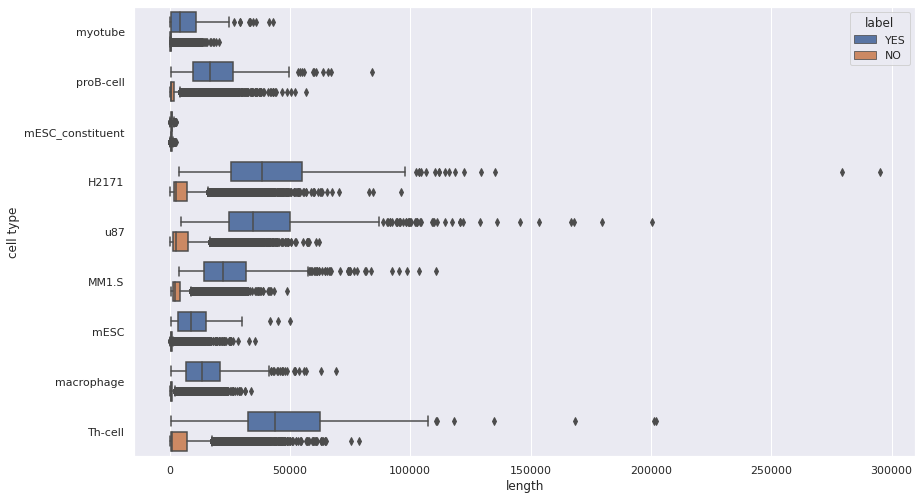

In [13]:
sns.set(rc={'figure.figsize':(14,8.27)})
sns.boxplot(data=full_data, x="length", y="cell type", hue="label")

We can see that mean SE length is greater than mean TE length for all the cell types. 

We decided to filter data and remove sequences shorter than 500 bp.

In [14]:
subset = full_data[full_data['length']>=500]

In [15]:
subset.groupby(['cell type', 'label'])['label'].count()

cell type         label
H2171             NO       16262
                  YES        357
MM1.S             NO       11669
                  YES        640
Th-cell           NO       13250
                  YES        436
mESC              NO        7376
                  YES        231
mESC_constituent  NO        8444
                  YES        615
macrophage        NO        7254
                  YES        960
myotube           NO         783
                  YES        460
proB-cell         NO        6590
                  YES        394
u87               NO       19086
                  YES       1073
Name: label, dtype: int64

<AxesSubplot:xlabel='length', ylabel='cell type'>

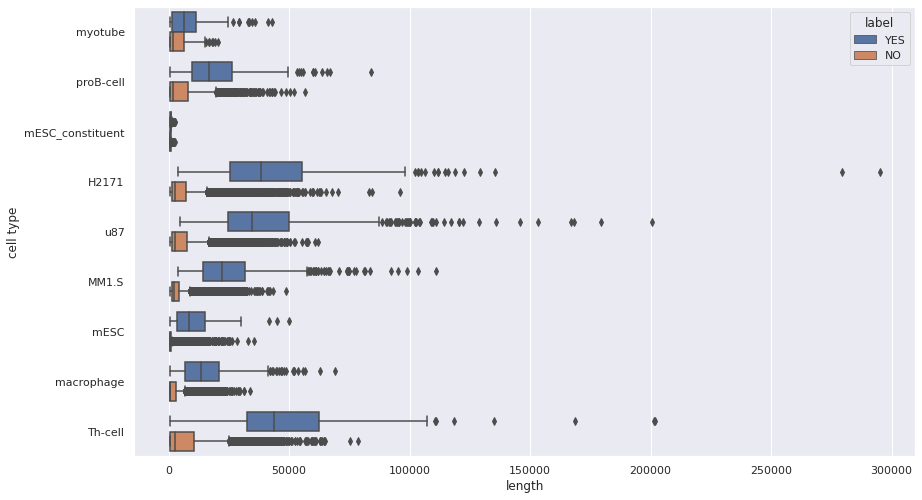

In [16]:
sns.boxplot(data=subset, x="length", y="cell type", hue="label")

## Required data format

For DNABERT-6 we need to create a dataset with sequences split into 6-mers and with label 0 (TE) or 1 (SE)

Let's look at example input for DNABERT

In [17]:
dnabert_data = pd.read_csv('dnabert_ft_train_data_example.tsv', sep="\t")

In [18]:
dnabert_data.head()

,sequence,label
0,CACAGC ACAGCC CAGCCA AGCCAG GCCAGC CCAGCC CAGC...,0
1,CTAATC TAATCT AATCTA ATCTAG TCTAGT CTAGTA TAGT...,1
2,GGAAGA GAAGAG AAGAGG AGAGGG GAGGGA AGGGAA GGGA...,1
3,CGAAAG GAAAGC AAAGCA AAGCAA AGCAAT GCAATC CAAT...,1
4,TGACTC GACTCC ACTCCC CTCCCA TCCCAA CCCAAA CCAA...,1


## Data convertation

Let's get DNA sequences from the coordinates for our data. The first step is converting into bed format

In [8]:
from fuc import pybed

In [20]:
bet_subset = subset.rename(columns={"chrom":"Chromosome", "start": "Start", "end": "End"})

In [21]:
bet_sets = {}
for name in table_names:
    bet_set = bet_subset[bet_subset['cell type']==name]
    bet_sets[name] = bet_set[['Chromosome', 'Start', 'End']]

In [22]:
for s in bet_sets:
    file = pybed.BedFrame.from_frame(meta=[], data=bet_sets[s])
    filename = 'bed_files/' + s + '.bed'
    file.to_file(filename)

We use bed2fasta https://meme-suite.org/meme/tools/bed2fasta to extract sequences using the coordinates in bed files. Here we choose UCSC mammalian genomes, Human and hg19 (for mm1.s, h2171, u87) or Nouse and mm9 for other cell types. The obtained bed files are stored in /fasta_files

Let's look at the obtained sequences

In [23]:
with open('fasta_files/myotube.fasta') as input_file:
    content = input_file.readlines()
for i in range(4):
    print(content[i])

>chr1:53870893-53913933(+) 

AAAATATTTTCTTTATGTGCCACCCTTTAGAAGATATATTTCATGCATAGTATGAGAATGAAAAAGCCAAGTTCAGTCTTTTTTCTTCCTTTCTATTCAGAGACAAGAATGAAGACTTTGCAAAGAGCTTCCCTTTGATTCCCTTCCAGCACTGTCAGCTGCCTGGATGTCCCTTGGATAATGTGTGGCTCGGTGGTTTTTCATTTTCTTGGGCAGGGATGAGCAGCAGTTGTGGCTGGAGACCAGACTGTGGCTCAGAGTTTGGGGAAAGTCCCTGGCTAGACTTGTCTGCAGATATTGTGACTGCTTTGAATTCCGTGTTATAGTCTGCTTTCTCCCTGTTCATAACATGGAAAAATGTCCATTTAATCACAGTTATATGCAGCACTCttttttttttttttttttttttAAATATCTACTCTTTTGCCAAGACTGGGGGAGGGGCAGTGCTTTCCTGTTATTTGCACCTGACTCACAATAAAGAAAGAGTCTCTGAATAGTACATCTTATCAGGAGCAGATCTGCACTTTTGACACAGGATAGGTAGCACCCTATCCTGAATTCACAACAGCTTGTTTGCTGGAGCTAAGTAGTTTATACTCAATTAAAAAAAAAAAAGGAGCCTGAAGTAATGTGTAACTTGAGGGAGACATGAGTAGGATATTTGTACGAAAGTAACATGCAAATTTTTATTGTTTCCAATTGTTTCTTACTTGTGAGGTAAGGTAAATATAACTAttttttttagaattaatttttttaattagggattttcttcatttacatttccaatgctatccaaaaagtccccaatacactcctcctgccactcccctacccacccactcccactttttggccctggcgttcccctgtactggggcatataaagtttgcaagtccaaagggcctctctttccagtgatggctgactaggccatcttttgatgcatatgcagctagactca

Let's convert all the sequence to the upper case and create a dictionary with sequences as a key and label as a value

In [24]:
sequential_data = {}
for name in table_names:
    filename = 'fasta_files/'+name+'.fasta'
    cell_type_data = {}
    with open(filename) as input_file:
        content = input_file.readlines()
    for i in range(len(content)):
        if i%2 == 0:
            label = subset[subset['cell type']==name].iloc[int(i/2)]['label']
            if label == 'YES':
                cell_type_data[content[i+1][:-1].upper()] = 1
            else:
                cell_type_data[content[i+1][:-1].upper()] = 0
    sequential_data[name] = cell_type_data
    print(name, ' done')

myotube  done
proB-cell  done
mESC_constituent  done
H2171  done
u87  done
MM1.S  done
mESC  done
macrophage  done
Th-cell  done


Tokenization

In [29]:
tokenized_data = {}
for name in table_names:
    seq = sequential_data[name]
    cell_type_data = {}
    cell_type_data['sequence'] = 'label'
    for i in seq:
        label = seq[i]
        new_i = []
        while(len(i)) >= 6:
            new_i.append(i[0:6])
            i = i[1:]
        new_i = ' '.join(new_i)
        cell_type_data[new_i] = label
    tokenized_data[name] = cell_type_data
    print(name, ' done')

myotube  done
proB-cell  done
mESC_constituent  done
H2171  done
u87  done
MM1.S  done
mESC  done
macrophage  done
Th-cell  done


Making tsv files

In [9]:
import csv

In [32]:
for name in table_names:
    filename = 'converted_data/'+name+'.tsv'
    my_dict = tokenized_data[name]
    with open(filename, 'w') as f:
        w = csv.writer(f, delimiter='\t', lineterminator='\n')
        w.writerows(my_dict.items())

# imPROSE data analysis and convertation (mESC dataset)

In [10]:
improse_data = pd.read_csv('improse_data/improse_data.csv')

In [11]:
improse_data

,chrom,start,end,Class,H3K27ac,H3K4me1,H3K4me3,H3K9me3,Brd4,Cdk8,...,Klf4,Prdm14,Tcfcp2I1,Nr5a2,AT_content,GC_content,phastCons,phastConsP,repeat_fraction,length
0,chr1,13049615,13050323,SE,0.2018,1.4146,0.0749,0.1198,0.7075,0.6613,...,0.4839,1.5489,0.8829,0.1934,0.552260,0.447740,0.057415,0.057418,0.810734,708
1,chr1,13061206,13061924,SE,0.1342,0.4785,0.5477,0.2809,0.4630,1.6258,...,0.0315,0.1724,0.1641,0.0000,0.572423,0.427577,0.128439,0.128439,0.738162,718
2,chr1,13063645,13065360,SE,0.6214,0.7748,0.1633,0.0000,1.5622,2.5607,...,0.1867,5.2407,0.0000,0.2011,0.592420,0.407580,0.220057,0.230713,0.092711,1715
3,chr1,13071010,13071067,SE,0.9484,1.8778,0.0000,0.0000,0.8669,1.8424,...,0.0000,1.0517,0.2885,0.4231,0.649123,0.350877,0.050386,0.050386,0.000000,57
4,chr1,13074460,13075741,SE,1.1076,0.7386,0.0000,0.0000,3.2876,3.8653,...,2.3268,63.2990,34.6054,0.1112,0.548009,0.451991,0.054896,0.054997,0.231850,1281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10015,chr18,76832964,76833528,TE,0.3865,0.2178,0.0000,0.0000,0.4477,0.6599,...,0.1842,1.9080,0.1139,0.0000,0.565603,0.434397,0.020204,0.020204,0.051418,564
10016,chr18,76833924,76834464,TE,0.5616,0.3867,0.0425,0.8427,1.4914,1.6630,...,0.4702,1.8830,0.3013,0.2002,0.477778,0.522222,0.362505,0.395681,0.057407,540
10017,chr18,76834846,76835327,TE,0.6197,0.7589,0.1468,0.0000,0.8867,0.8208,...,0.2163,4.1193,0.0956,0.0000,0.544699,0.455301,0.379287,0.403342,0.000000,481
10018,chr18,76931680,76932478,TE,0.0000,0.1024,0.0000,0.0000,0.2146,0.1972,...,0.2808,0.8869,0.0367,0.0883,0.557644,0.442356,0.030260,0.036487,0.540100,798


In [12]:
improse_data = improse_data[['chrom', 'start', 'end', 'Class']]
improse_data['length'] = improse_data['end'] - improse_data['start']

/tmp/ipykernel_37259/3647218385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improse_data['length'] = improse_data['end'] - improse_data['start']


In [13]:
improse_data

,chrom,start,end,Class,length
0,chr1,13049615,13050323,SE,708
1,chr1,13061206,13061924,SE,718
2,chr1,13063645,13065360,SE,1715
3,chr1,13071010,13071067,SE,57
4,chr1,13074460,13075741,SE,1281
...,...,...,...,...,...
10015,chr18,76832964,76833528,TE,564
10016,chr18,76833924,76834464,TE,540
10017,chr18,76834846,76835327,TE,481
10018,chr18,76931680,76932478,TE,798


In [14]:
improse_data.groupby(['Class'])['Class'].count()

Class
SE     646
TE    9374
Name: Class, dtype: int64

In [15]:
improse_data.groupby(['Class'])['length'].max()

Class
SE    2504
TE    2532
Name: length, dtype: int64

In [16]:
improse_data.groupby(['Class'])['length'].min()

Class
SE    4
TE    1
Name: length, dtype: int64

<AxesSubplot:xlabel='length', ylabel='Class'>

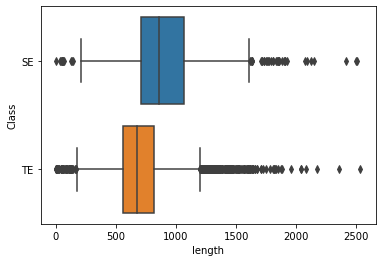

In [17]:
sns.boxplot(data=improse_data, x="length", y="Class")

In [18]:
improse_data = improse_data[improse_data['length']>=500]

In [19]:
improse_data.groupby(['Class'])['Class'].count()

Class
SE     615
TE    7954
Name: Class, dtype: int64

<AxesSubplot:xlabel='length', ylabel='Class'>

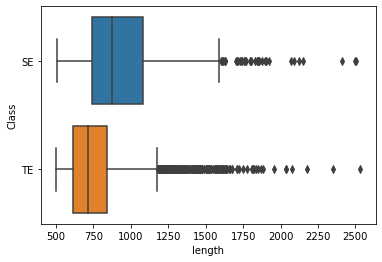

In [20]:
sns.boxplot(data=improse_data, x="length", y="Class")

In [21]:
bet_subset = improse_data.rename(columns={"chrom":"Chromosome", "start": "Start", "end": "End"})[['Chromosome', 'Start', 'End']]

In [22]:
file = pybed.BedFrame.from_frame(meta=[], data=bet_subset)
file.to_file('bed_files/improse.bed')

making fasta using https://meme-suite.org/meme/tools/bed2fasta tool (mouse genome version mm9)

In [23]:
sequential_data = {}
with open('fasta_files/improse.fasta') as input_file:
    content = input_file.readlines()
    for i in range(len(content)):
        if i%2 == 0:
            label = improse_data.iloc[int(i/2)]['Class']
            if label == 'SE':
                sequential_data[content[i+1][:-1].upper()] = 1
            else:
                sequential_data[content[i+1][:-1].upper()] = 0

In [24]:
tokenized_data = {}
tokenized_data['sequence'] = 'label'
for i in sequential_data:
    label = sequential_data[i]
    new_i = []
    while(len(i)) >= 6:
        new_i.append(i[0:6])
        i = i[1:]
    new_i = ' '.join(new_i)
    tokenized_data[new_i] = label

In [25]:
with open('converted_data/improse.tsv', 'w') as f:
    w = csv.writer(f, delimiter='\t', lineterminator='\n')
    w.writerows(tokenized_data.items())